In [2]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor
from sklearn.datasets import make_moons

In [4]:
class DiscreteFlow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 128, v: int = 128):
        """
            dim (int): 输入数据的维度，默认为2
            h (int): 隐藏层大小，用于嵌入层和网络层的维度，默认为128
            v (int): 词汇表大小，表示每个位置可能的离散值数量，默认为128
        """
        super().__init__()
        self.v = v  # 词汇表大小
        # 离散-》连续
         # 输出：[batch_size, dim, h]
        self.embed = nn.Embedding(v, h) 
        self.net = nn.Sequential(
            nn.Linear(dim * h + 1, h), nn.ELU(),  # 输入维度为dim*h+1(包含时间t)
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim * v))  # 输出维度为dim*v，表示每个位置的概率分布
    
    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        """
        Input:
            x_t (Tensor): 输入数据，形状为[batch_size, dim]
            t (Tensor): 时间步，形状为[batch_size]
        Return:
            Tensor: 每个位置的概率分布，形状为[batch_size, dim, v]
        """
        # 1. 将时间t扩展为列向量
        t_expanded = t[:, None]  # [batch_size, 1]
        
        # 2. 获取输入x_t的嵌入表示
        x_embedded = self.embed(x_t)  # [batch_size, dim, h]
        
        # 3. 将嵌入展平为2D张量
        x_flat = x_embedded.flatten(1, 2)  # [batch_size, dim*h]
        
        # 4. 在最后一个维度上拼接时间t和展平的嵌入
        combined = torch.cat((t_expanded, x_flat), -1)  # [batch_size, dim*h + 1]
        
        # 5. 通过网络处理
        output = self.net(combined)  # [batch_size, dim*v]
        
        # 6. 重塑输出为所需的形状
        result = output.reshape(list(x_t.shape) + [self.v])  # [batch_size, dim, v]
        
        return result

$p(x_{t+1}|x_t, t) = \text{softmax}(f_\theta(t, \text{embed}(x_t)))$

其中：

1. $\text{embed}(x_t)$ 是输入离散值的嵌入表示：$\mathbb{Z}^d \rightarrow \mathbb{R}^{d \times h}$
2. $f_\theta$ 是神经网络，输出每个位置上所有可能离散值的logits：$\mathbb{R}^{d \times h + 1} \rightarrow \mathbb{R}^{d \times v}$
3. $\text{softmax}$ 将logits转换为概率分布

- 连续流匹配中的网络 ：

    - 输出是向量场（导数）
    - 指导数据点如何连续移动
    - 使用 ODE 求解器进行积分
- 离散流匹配中的网络 ：

    - 输出是概率分布（logits）
    - 预测每个位置上下一个可能的离散值的概率
    - 通过采样来确定下一个状态

# Training

离散流匹配中的"插值"操作：

```python
x_t = torch.where(torch.rand(batch_size, 2) < t[:, None], x_1, x_0)
```

这行代码实现的是离散数据的概率插值，而不是连续数据中的线性插值。其工作原理是：

1. **基本原理**：
   - 在时间 t 处，每个位置有 t 的概率选择目标值（x_1），有 (1-t) 的概率保持初始值（x_0）
   - t 越接近 0，越倾向于保持 x_0
   - t 越接近 1，越倾向于选择 x_1

2. **具体实现**：
   ```python
   torch.rand(batch_size, 2) < t[:, None]
   ```
   - `torch.rand` 生成 [0,1] 之间的随机数
   - `t[:, None]` 将 t 扩展为 [batch_size, 1] 以便广播
   - 当随机数小于 t 时选择 x_1，否则选择 x_0

3. **示例**：
   假设 t = 0.3：
   - 每个位置有 30% 的概率选择 x_1
   - 有 70% 的概率选择 x_0
   
这种方式与连续流中的线性插值 `(1-t) * x_0 + t * x_1` 不同，因为：
1. 离散值之间无法进行算术运算
2. 通过概率采样来模拟"渐进"变化
3. 保持了数据的离散性质

这种概率插值方法确保了在训练过程中，模型能够学习到从初始分布到目标分布的渐进转换过程。

计算预测值与目标值的交叉熵损失
- flatten(0, 1) ：将batch和维度展平
- 使用交叉熵损失因为这是分类问题

Training: 100%|██████████| 10000/10000 [00:26<00:00, 372.33it/s]


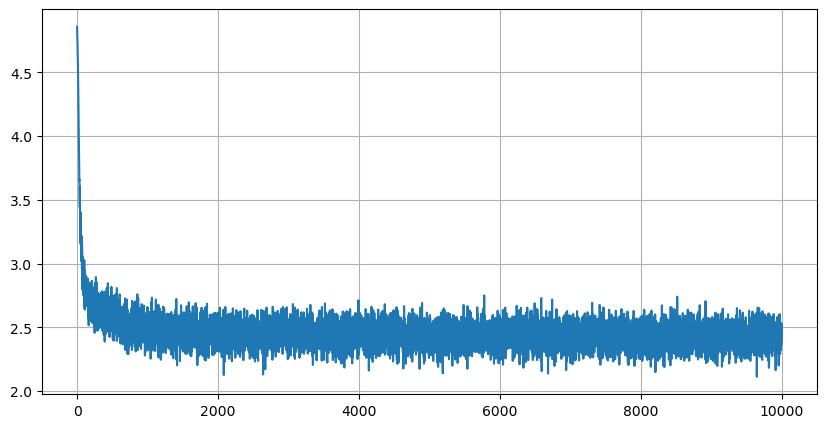

In [7]:
from tqdm import tqdm
import matplotlib.pyplot as plt
config={
    "optimizer": "Adam",
    "learning_rate": 0.001,
    "loss_fn": "CrossEntropyLoss",
    "batch_size": 256,
    "vocab_size": 128,
    "epochs": 10000}
batch_size = 512
vocab_size = 128
model = DiscreteFlow(v=vocab_size)
optim = torch.optim.AdamW(model.parameters(), lr=0.001) 


losses = []

for epoch in tqdm(range(10000), desc="Training"):
    # 生成目标分布数据(月牙形状)并离散化到vocab_size范围内
    x_1 = Tensor(make_moons(batch_size, noise=0.05)[0]) 
    #将数据缩放（×35）和平移（+50）后裁剪到[0, 127]范围，然后四舍五入为整数 
    x_1 = torch.round(torch.clip(x_1 * 35 + 50, min=0.0, max=vocab_size - 1)).long()
    # 生成均匀分布的初始数据
    x_0 = torch.randint(low=0, high=vocab_size, size=(batch_size, 2))
    # 生成随机时间点t
    t = torch.rand(batch_size)
    # 根据时间t插值得到中间分布x_t
    x_t = torch.where(torch.rand(batch_size, 2) < t[:, None], x_1, x_0)
    # 前向传播计算预测结果
    logits = model(x_t, t)
    # 计算交叉熵损失
    loss = nn.functional.cross_entropy(logits.flatten(0, 1), x_1.flatten(0, 1)).mean()
    # 记录损失值
    losses.append(loss.item())
    # 反向传播更新参数
    optim.zero_grad()
    loss.backward()
    optim.step()

# 绘制损失函数图
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.grid(True)
plt.show()

# Sampling

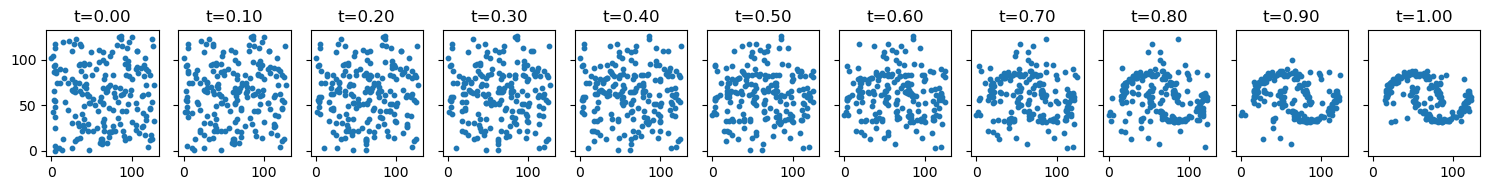

In [8]:
#生成200个随机初始点
x_t = torch.randint(low=0, high=vocab_size, size=(200, 2))
t = 0.0
results = [(x_t, t)]
while t < 1.0 - 1e-3:
    # 获取模型预测的转移概率
    p1 = torch.softmax(model(x_t, torch.ones(200) * t), dim=-1)
    # 计算时间步长
    h = min(0.1, 1.0 - t)
    # 将当前状态转换为one-hot编码
    one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
    # 计算概率变化率
    u = (p1 - one_hot_x_t) / (1.0 - t)
    # 根据概率采样下一个状态
    x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
    t += h
    results.append((x_t, t))

fig, axes = plt.subplots(1, len(results), figsize=(15, 2), sharex=True, sharey=True)

for (x_t, t), ax in zip(results, axes):
    ax.scatter(x_t.detach()[:, 0], x_t.detach()[:, 1], s=10)
    ax.set_title(f't={t:.2f}')

plt.tight_layout()
plt.show()